# **Redes Adversárias Generativas - MNIST - PyTorch**


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 6.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=32ca826465f78d71b49717aff79244d7fbed75ebca41cced5b95d3104a99ad99
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


### **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from google.colab import drive, files
from zipfile import ZipFile
from PIL import Image 

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

!nvidia-smi

drive.mount('/content/gdrive')

Usando: cuda
Thu Dec 24 23:50:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                           

### **Definição das constantes**

In [ ]:
REAL_BATCH_SIZE = 64
BATCH_SIZE = REAL_BATCH_SIZE
LATENT_DIM = 100
RESOLUTION = 64
NUM_EPOCHS = 50

FIG_PATH = '/content/gdrive/MyDrive/01 - Mestrado/Materiais de Estudo/Notebooks/02_Generative_Adversarial_Networks/DCGAN_CatsVsDogs_Fake_Images/'
MODEL_PATH = '/content/gdrive/MyDrive/01 - Mestrado/Materiais de Estudo/Notebooks/Modelos/'

### **Preparação dos dados**

**Download dos dados com a API do Kaggle**

Primeiro precisamos fazer o *upload* da API do Kaggle que nos permitirá fazer o *download* do *dataset Dogs vs Cats*, que pode ser encontrado em https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition.


In [ ]:
files.upload()

Em seguida, criamos o arquivo e fazemos as configurações necessárias para utilizar a API

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Com tudo configurado, fazemos o *download* do dados. 

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 797M/814M [00:07<00:00, 147MB/s]
100% 814M/814M [00:07<00:00, 115MB/s]


Como resultado, um arquivo nomeado *dogs-vs-cats-redux-kernels-edition.zip* é criado no diretório */content/*.

In [ ]:
ls /content/

dogs-vs-cats-redux-kernels-edition.zip  gdrive/  kaggle.json  sample_data/


**Extração dos arquivos zip**

Dentro do arquivo *dogs-vs-cats-redux-kernels-edition.zip* estão dois arquivos zip, um contendo imagens de treinamento, *train.zip*, e outro contendo imagens de teste, *test.zip*. A extração de ambos os arquivos é feita no diretório /content/.

In [ ]:
with ZipFile(file='dogs-vs-cats-redux-kernels-edition.zip', mode='r') as f:
    f.extract('train.zip')

!ls /content/

dogs-vs-cats-redux-kernels-edition.zip	kaggle.json  train.zip
gdrive					sample_data


**Construção da subclasse *DogsDataset***

In [ ]:
class DogsDataset(Dataset):
    
    def __init__(self, path_zipfile=None, transforms=None):
        super(DogsDataset, self).__init__()
        self.path_zipfile = path_zipfile
        self.image_names = self.__extract_zipfile()
        self.labels = self.__create_labels()
        self.transforms = transforms

    def __extract_zipfile(self):
        with ZipFile(file=self.path_zipfile, mode='r') as file:
            file.extractall()
            image_names = file.namelist()
            image_names = image_names[1::]
            image_names = image_names[12500:]
        return image_names

    def __create_labels(self):
        labels = [0 if image_name.find('cat') != -1 else 1 for image_name in self.image_names]
        return labels

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        
        if isinstance(self.image_names[idx], str):
            image_path = '/content/' + self.image_names[idx]
            image = Image.open(fp=image_path)
            if self.transforms:
                image = self.transforms(image)
            label = torch.tensor(np.array(self.labels[idx]))
            
        if isinstance(self.image_names[idx], list):
            image_paths = ['/content/' + image_name for image_name in self.image_names[idx]]
            image = [Image.open(fp=image_path) for image_path in image_paths]
            if self.transforms:
                image = [self.transforms(img) for img in image]
                image = torch.stack(image)
            label = self.tensor(np.array(self.labels[idx]))

        return image, label

**Criando o *dataset* de treino**

Transformações aplicadas às imagens de dígitos manuscritos
- *transforms.Resize()*: padroniza todas as imagens do *dataset* para ter dimensão $(3, 64, 64)$
- *transforms.ToTensor()*: converte as imagens para *torch.tensor* e normaliza os pixels para o intervalo $[0, 1]$
- *dcgan_pixel_normalization()*: ajusta a normalização dos pixels para o intervalo $[-1, 1]$

In [ ]:
def dcgan_pixel_normalization(x):
    x_min, x_max = -1., 1.
    return x * (x_max - x_min) + x_min

def dcgan_pixel_denormalization(x):
    return (x - x.min())/(x.max() - x.min())

dataset_transforms = transforms.Compose([transforms.Resize((RESOLUTION, RESOLUTION)),
                                        transforms.ToTensor(),
                                        transforms.Lambda(lambd=dcgan_pixel_normalization)])

Download das amostras de treinamento

In [ ]:
train_dataset = DogsDataset(path_zipfile='/content/train.zip', transforms=dataset_transforms)

print('Número de amostras do dataset: ', len(train_dataset.labels))

Número de amostras do dataset:  12500


Construção do *dataloader* de treinamento

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=REAL_BATCH_SIZE, shuffle=True)
print(f'{len(train_dataloader)} mini-batches de {REAL_BATCH_SIZE} amostras para treinamento')

196 mini-batches de 64 amostras para treinamento


**Exemplos de imagens do dataset**

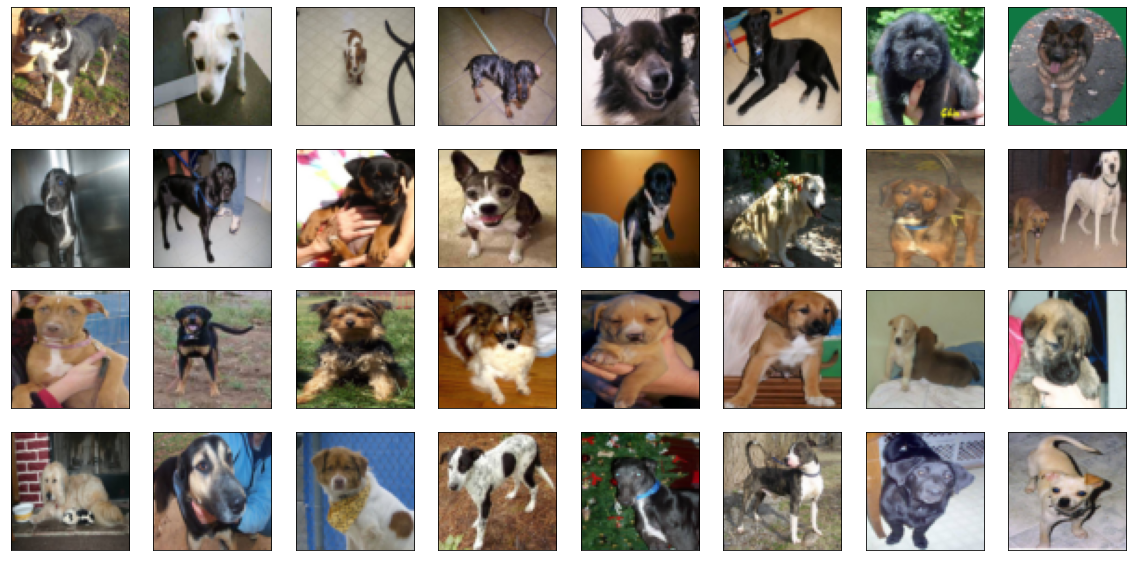

In [ ]:
images, labels = next(iter(train_dataloader))
fig = plt.figure(figsize=(20, 10))

images = images.transpose(2, 1).transpose(3, 2)
images = dcgan_pixel_denormalization(images)

for i, (image, label) in enumerate(zip(images[0:32], labels[0:32])):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

### **Funções auxiliares**

In [ ]:
def save_generated_images(model, gaussian_noise, batch_epoch, total_batch_epoch, path, 
                          figname='generated_images_epoch', format='.png', plot_step=500):
    
    if batch_epoch in range(1, total_batch_epoch+1, plot_step):
        model.eval()
        generated_images = model(gaussian_noise)
        generated_images = dcgan_pixel_denormalization(generated_images)
        generated_images = torch.transpose(torch.transpose(generated_images, 2, 1), 3, 2)
        model.train()

        fig = plt.figure(figsize=(15, 25));
        with torch.no_grad():
            for i, generated_image in enumerate(generated_images):
                fig.add_subplot(16, 8, i+1)
                plt.imshow(generated_image.cpu(), cmap='gray')
                plt.xticks([])
                plt.yticks([])
            fig.savefig(fname=path+figname+str(batch_epoch-1)+format)
            plt.close(fig)
    return

In [ ]:
def progressbar(batch_epoch, total_batch_epoch, D_batch_real_loss, D_batch_fake_loss, G_batch_fake_loss):
    pbar = 'Batch: {}/'.format(batch_epoch) + \
           '{} - '.format(total_batch_epoch) + \
           'D_real_loss: {:.3f} - '.format(D_batch_real_loss) + \
           'D_fake_loss: {:.3f} - '.format(D_batch_fake_loss) + \
           'G_loss: {:.3f}'.format(G_batch_fake_loss)
    print(pbar)
    return    

In [ ]:
def create_labels(real_batch_size, device):
    D_real_labels = torch.ones(size=(real_batch_size, 1)).to(device)
    D_fake_labels = torch.zeros(size=(real_batch_size, 1)).to(device)
    G_fake_labels = torch.ones(size=(2*real_batch_size, 1)).to(device)
    return D_real_labels, D_fake_labels, G_fake_labels

In [ ]:
def plot_losses(D_real_losses, D_fake_losses, G_fake_losses):
    
    total_batch_epoch = range(1, len(D_real_losses)+1)

    fig = plt.figure(figsize=(16, 10))
    fig.add_subplot(2, 1, 1)
    plt.plot(total_batch_epoch, D_real_losses)
    plt.plot(total_batch_epoch, D_fake_losses)
    plt.title("Discriminator's Losses vs Num. Batches")
    plt.xlabel('Num. Batches')
    plt.ylabel('Losses')

    fig.add_subplot(2, 1, 2)
    plt.plot(total_batch_epoch, G_fake_losses)
    plt.title("Generator's Loss vs Num. Batches")
    plt.xlabel('Num. Batches')
    plt.ylabel('Losses')
    return

In [ ]:
def train_discriminator(D_model, D_optimizer, criterion, real_samples, D_real_labels, fake_samples, D_fake_labels):

    D_optimizer.zero_grad()

    probs = D_model(real_samples)  
    D_batch_real_loss = criterion(probs, D_real_labels)
    D_batch_real_loss.backward()

    probs = D_model(fake_samples)
    D_batch_fake_loss = criterion(probs, D_fake_labels)
    D_batch_fake_loss.backward()

    D_optimizer.step()
    return D_batch_real_loss.item(), D_batch_fake_loss.item() 

In [ ]:
def train_generator(D_model, G_optimizer, criterion, fake_samples, G_fake_labels, real_samples):
    G_optimizer.zero_grad()
    probs = D_model(fake_samples)
    G_batch_fake_loss = criterion(probs, G_fake_labels)
    G_batch_fake_loss.backward()
    G_optimizer.step()   
    return G_batch_fake_loss.item()

**Função de treinamento**

In [ ]:
@torch.enable_grad()
def train(dataloader, generator, discriminator, G_criterion, D_criterion, G_optimizer, D_optimizer, device, 
          real_batch_size, total_epoch, running_epoch, fig_path):

    D_epoch_real_losses, D_epoch_fake_losses, G_epoch_fake_losses = [], [], []
    D_real_labels, D_fake_labels, G_fake_labels = create_labels(real_batch_size=real_batch_size, device=device)

    generator.train()
    discriminator.train()    
    for i, (real_samples, _) in enumerate(dataloader):

        # Fase I: Treinamento da rede discriminativa
        real_samples = real_samples.to(device)
        coding_samples = torch.randn(D_fake_labels.shape[0], generator.latent_dim).to(device)  
        fake_samples = generator(coding_samples)   
        D_batch_real_loss, D_batch_fake_loss = train_discriminator(D_model=discriminator, 
                                                                   D_optimizer=D_optimizer, 
                                                                   criterion=D_criterion,
                                                                   real_samples=real_samples, 
                                                                   D_real_labels=D_real_labels,
                                                                   fake_samples=fake_samples, 
                                                                   D_fake_labels=D_fake_labels)
        
        # Fase 2: Treinamento da rede generativa
        coding_samples = torch.randn(G_fake_labels.shape[0], generator.latent_dim).to(device)
        fake_samples = generator(coding_samples) 
        G_batch_fake_loss = train_generator(D_model=discriminator, 
                                            G_optimizer=G_optimizer, 
                                            criterion=G_criterion,
                                            fake_samples=fake_samples, 
                                            G_fake_labels=G_fake_labels,
                                            real_samples=real_samples)   


        batch_epoch = (i+1) + (running_epoch - 1)*len(dataloader)
        
        save_generated_images(model=generator, 
                              gaussian_noise=coding_samples, 
                              batch_epoch=batch_epoch, 
                              total_batch_epoch=len(dataloader)*total_epoch, 
                              plot_step=500, 
                              path=fig_path)

        progressbar(batch_epoch=batch_epoch, 
                    total_batch_epoch=len(dataloader)*total_epoch,
                    D_batch_real_loss=D_batch_real_loss, 
                    D_batch_fake_loss=D_batch_fake_loss, 
                    G_batch_fake_loss=G_batch_fake_loss)

        D_epoch_real_losses.append(D_batch_real_loss)
        D_epoch_fake_losses.append(D_batch_fake_loss)
        G_epoch_fake_losses.append(G_batch_fake_loss)

    return D_epoch_real_losses, D_epoch_fake_losses, G_epoch_fake_losses

**Função main**

In [ ]:
def main(train_dataloader, generator, discriminator, G_criterion, D_criterion, G_optimizer, 
         D_optimizer, device, total_epoch, real_batch_size, fig_path, model_path=None):
    
    D_real_losses = []
    D_fake_losses = []
    G_fake_losses = []

    for e in range(1, total_epoch+1):
        D_epoch_real_losses, D_epoch_fake_losses, G_epoch_fake_losses = train(dataloader=train_dataloader,
                                                                              generator=generator,
                                                                              discriminator=discriminator,
                                                                              G_criterion=G_criterion,
                                                                              D_criterion=D_criterion,
                                                                              G_optimizer=G_optimizer,
                                                                              D_optimizer=D_optimizer,
                                                                              device=device, 
                                                                              real_batch_size=real_batch_size,
                                                                              total_epoch=total_epoch,
                                                                              running_epoch=e,
                                                                              fig_path=fig_path)
        D_real_losses.extend(D_epoch_real_losses)
        D_fake_losses.extend(D_epoch_fake_losses)
        G_fake_losses.extend(G_epoch_fake_losses)
    
    plot_losses(D_real_losses=D_real_losses, D_fake_losses=D_fake_losses, G_fake_losses=G_fake_losses)
    return D_real_losses, D_fake_losses, G_fake_losses

### **Modelo - DCGAN**

Aqui criamos um batch de imagens do dataset e de códigos latentes que será passado pelas redes para verificar seus funcionamentos.

In [ ]:
# Ruído gaussiano = entrada da rede generativa:
code_samples = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)

# Amostras do dataset de treinamento:
real_images, _ = next(iter(train_dataloader))
real_images = real_images.to(device)         

print('code_samples.shape: ', code_samples.shape)
print('real_images.shape: ', real_images.shape)
print('real_images.max: ', real_images.max().item())
print('real_images.min: ', real_images.min().item())

code_samples.shape:  torch.Size([64, 100])
real_images.shape:  torch.Size([64, 3, 64, 64])
real_images.max:  1.0
real_images.min:  -1.0


**Rede generativa**


In [ ]:
class GenerativeModel(nn.Module):
    def __init__(self, latent_dim):
        super(GenerativeModel, self).__init__()
        self.latent_dim = latent_dim
        
        self.linear0 = nn.Linear(self.latent_dim, 256*4*4)
        self.batchnorm0 = nn.BatchNorm2d(256)
        self.leaky_relu0 = nn.LeakyReLU(negative_slope=0.2)
        self.convt1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.batchnorm1 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.convt2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.convt3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.convt4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.tanh4 = nn.Tanh()        

    def forward(self, x):
        x = self.linear0(x)
        x = self.leaky_relu0(self.batchnorm0(x.view(x.shape[0], 256, 4, 4)))
        x = self.leaky_relu1(self.batchnorm1(self.convt1(x)))
        x = self.leaky_relu2(self.batchnorm2(self.convt2(x)))
        x = self.leaky_relu3(self.batchnorm3(self.convt3(x)))
        x = self.tanh4(self.convt4(x))
        return x


# Passamos o batch para verificar o funcionamento
model = GenerativeModel(latent_dim=LATENT_DIM).to(device)
fake_images = model(code_samples)

print('code_samples.shape: ', code_samples.shape)
print('fake_images.shape: ', fake_images.shape)

list_parameters = list(model.named_parameters())
num_param = [torch.numel(param) for _, param in list_parameters]
total_param = sum(num_param)
print('Numero de parâmetros: ', total_param)

code_samples.shape:  torch.Size([64, 100])
fake_images.shape:  torch.Size([64, 3, 64, 64])
Numero de parâmetros:  1104547


**Rede discriminativa**


In [ ]:
class DiscriminativeModel(nn.Module):
    def __init__(self):
        super(DiscriminativeModel, self).__init__()

        self.conv0 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.leaky_relu0 = nn.LeakyReLU(negative_slope=0.2)
        self.conv1 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='zeros')
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)    
        self.linear4 = nn.Linear(4096, 1)
        self.sigmoid4 = nn.Sigmoid()   
    
    def forward(self, x):
        x = self.leaky_relu0(self.conv0(x))                     
        x = self.leaky_relu1(self.batchnorm1(self.conv1(x)))    
        x = self.leaky_relu2(self.batchnorm2(self.conv2(x)))    
        x = self.leaky_relu3(self.batchnorm3(self.conv3(x)))    
        x = x.view(x.shape[0], -1)
        x = self.sigmoid4(self.linear4(x))
        return x

# Passamos o batch para verificar o funcionamento
model = DiscriminativeModel().to(device)
real_probs = model(real_images)
fake_probs = model(fake_images)

print('real_images.shape: ', real_images.shape)
print('fake_images.shape: ', fake_images.shape)
print('real_probs.shape: ', real_probs.shape)
print('fake_probs.shape: ', fake_probs.shape)

list_parameters = list(model.named_parameters())
num_param = [torch.numel(param) for _, param in list_parameters]
total_param = sum(num_param)
print('Numero de parâmetros: ', total_param)

real_images.shape:  torch.Size([64, 3, 64, 64])
fake_images.shape:  torch.Size([64, 3, 64, 64])
real_probs.shape:  torch.Size([64, 1])
fake_probs.shape:  torch.Size([64, 1])
Numero de parâmetros:  695137


### **Treinamento do modelo**

**Instâncias das redes, dos otimizadores e da função custo**

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.normal_(layer.bias, mean=0.0, std=0.02)

    if type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.normal_(layer.bias, mean=0.0, std=0.02)
    
    if type(layer) == nn.ConvTranspose2d:
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
        nn.init.normal_(layer.bias, mean=0.0, std=0.02)

In [ ]:
# Instancias dos modelos
DCGAN_Generator = GenerativeModel(latent_dim=LATENT_DIM).to(device)
DCGAN_Discriminator = DiscriminativeModel().to(device)

# Alteração da inicialização dos pesos
DCGAN_Generator.apply(init_weights)
DCGAN_Discriminator.apply(init_weights)

# Instâncias dos otimizadores
G_optimizer = optim.Adam(DCGAN_Generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(DCGAN_Discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Função custo - Binary Cross-Entropy
D_criterion = nn.BCELoss()
G_criterion = nn.BCELoss()

# DataLoader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=REAL_BATCH_SIZE, shuffle=True, drop_last=True)

**Funcionamento da rede generativa antes do treinamento**

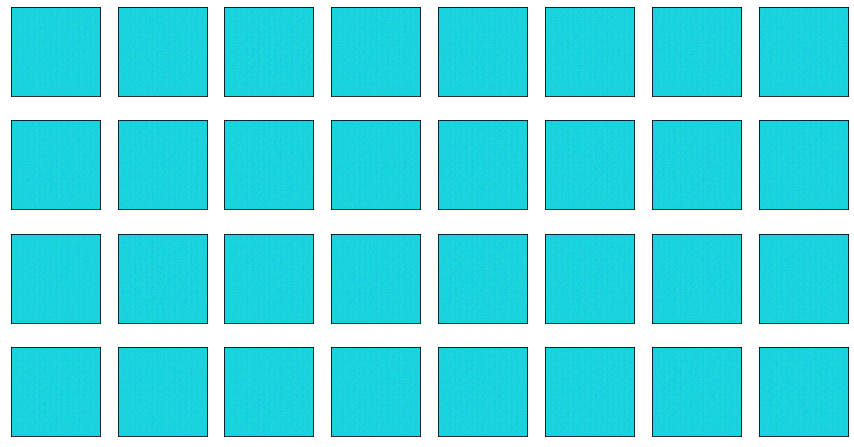

In [ ]:
DCGAN_Generator.eval()
gaussian_noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)

fake_images = DCGAN_Generator(gaussian_noise)
fake_images = dcgan_pixel_denormalization(fake_images)
fake_images = torch.transpose(torch.transpose(fake_images, 2, 1), 3, 2)

fig = plt.figure(figsize=(15, 8));

with torch.no_grad():
    for i, fake_image in enumerate(fake_images[0:32]):
        fig.add_subplot(4, 8, i+1)
        plt.imshow(fake_image.cpu(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

**Treinamento**

In [ ]:
info = 'Treinamento da DCGAN com código de dimensão ' + str(LATENT_DIM)
info = info.center(len(info) + 40)
print()
print(len(info)*'=')
print(info)
print(len(info)*'=')
D_real_losses, D_fake_losses, G_fake_losses = main(train_dataloader=train_dataloader, 
                                                   generator=DCGAN_Generator,
                                                   discriminator=DCGAN_Discriminator,
                                                   G_criterion=G_criterion,
                                                   D_criterion=D_criterion,
                                                   G_optimizer = G_optimizer,
                                                   D_optimizer = D_optimizer,
                                                   device=device,
                                                   total_epoch=NUM_EPOCHS,
                                                   real_batch_size=REAL_BATCH_SIZE,
                                                   fig_path=FIG_PATH)

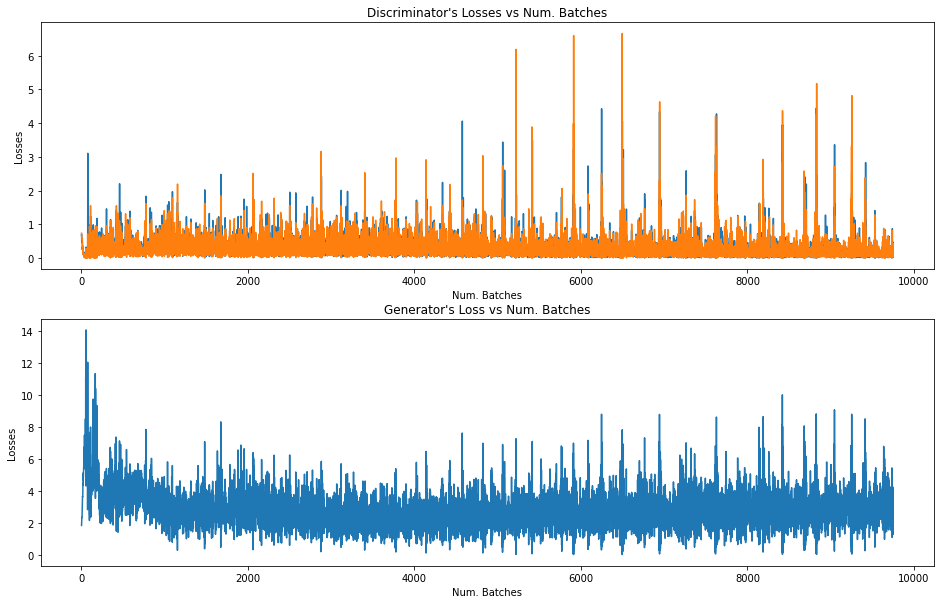

In [ ]:
plot_losses(D_real_losses, D_fake_losses, G_fake_losses)

**Funcionamento da rede generativa após o treinamento**

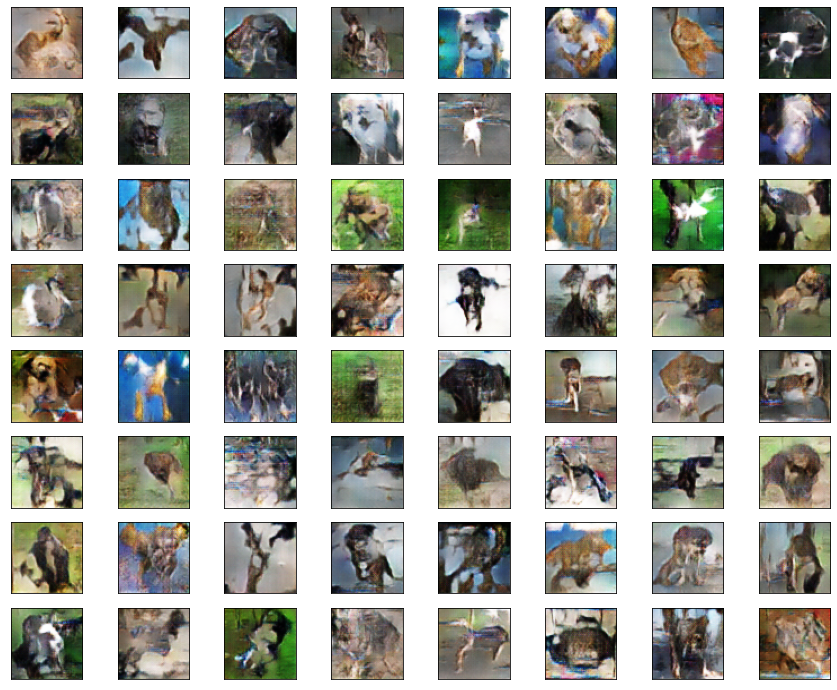

In [ ]:
DCGAN_Generator.eval()
gaussian_noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)

fake_images = DCGAN_Generator(gaussian_noise)
fake_images = dcgan_pixel_denormalization(fake_images)
fake_images = torch.transpose(torch.transpose(fake_images, 2, 1), 3, 2)

fig = plt.figure(figsize=(15, 25));

with torch.no_grad():
    for i, fake_image in enumerate(fake_images):
        fig.add_subplot(16, 8, i+1)
        plt.imshow(fake_image.cpu(), cmap='gray')
        plt.xticks([])
        plt.yticks([])